In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# --- Configuration ---
DATA_FILE_PATH = "/content/time_series_forecasting_data.csv"  # !!! REPLACE WITH YOUR FILE PATH !!!
TARGET_VARIABLE = 'svr1'  # Column to predict
DATETIME_COLUMN = 'datetime'
N_STEPS = 10  
N_FEATURES = 1 
LSTM_UNITS = 50
EPOCHS = 20 
BATCH_SIZE = 32

In [3]:
# --- 1. Load Data ---
print(f"Loading data from {DATA_FILE_PATH} for LSTM...")
try:
    df = pd.read_csv(DATA_FILE_PATH)
except FileNotFoundError:
    print(f"ERROR: File not found at {DATA_FILE_PATH}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

print("Data loaded. Shape:", df.shape)

Loading data from /content/time_series_forecasting_data.csv for LSTM...
Data loaded. Shape: (443, 6)


In [4]:
# --- 2. Preprocessing for LSTM ---
print("\nPreprocessing data for LSTM...")
if DATETIME_COLUMN not in df.columns:
    print(f"ERROR: Datetime column '{DATETIME_COLUMN}' not found.")
    exit()
df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
df = df.set_index(DATETIME_COLUMN)
df = df.sort_index()

if TARGET_VARIABLE not in df.columns:
    print(f"ERROR: Target variable '{TARGET_VARIABLE}' not found.")
    exit()

# Select the target variable and handle NaNs
ts_data_lstm = df[[TARGET_VARIABLE]].copy() # Keep as DataFrame
ts_data_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
ts_data_lstm.dropna(inplace=True)


if ts_data_lstm.empty:
    print(f"ERROR: No data left for '{TARGET_VARIABLE}' after preprocessing for LSTM.")
    exit()

print(f"Using '{TARGET_VARIABLE}' series. Length: {len(ts_data_lstm)}")

# Scale data (LSTMs are sensitive to feature scales)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data_lstm)


Preprocessing data for LSTM...
Using 'svr1' series. Length: 443


In [5]:
# --- 3. Create Sequences for Supervised Learning ---
# Function to create input sequences (X) and output values (y)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0]) # Using N_FEATURES=1 (univariate)
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data, N_STEPS)

if X_seq.shape[0] == 0:
    print(f"ERROR: Could not create sequences. Data length ({len(scaled_data)}) might be less than N_STEPS ({N_STEPS}).")
    exit()

# Reshape X to be [samples, time_steps, features] as required by LSTM
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], N_FEATURES))
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

X_seq shape: (433, 10, 1), y_seq shape: (433,)


In [6]:
# --- 4. Data Splitting ---
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    print("ERROR: Not enough data after splitting for training or testing.")
    exit()

Train size: 346, Test size: 87


In [7]:
# --- 5. Build and Compile LSTM Model ---
print("\nBuilding LSTM model...")
model_lstm = Sequential()
model_lstm.add(LSTM(units=LSTM_UNITS, activation='relu',
                    input_shape=(N_STEPS, N_FEATURES),
                    return_sequences=True)) # return_sequences=True if stacking LSTMs
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=LSTM_UNITS//2, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1)) # Output layer: 1 unit for univariate prediction

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()



Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.1956 - val_loss: 0.0831
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1499 - val_loss: 0.0644
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1161 - val_loss: 0.0494
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0871 - val_loss: 0.0474
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0693 - val_loss: 0.0467
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0655 - val_loss: 0.0467
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0634 - val_loss: 0.0466
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0633 - val_loss: 0.0466
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0563 - val_loss: 0.0467
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0562 - val_loss: 0.0470
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0592 - val_loss: 0.0466
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 

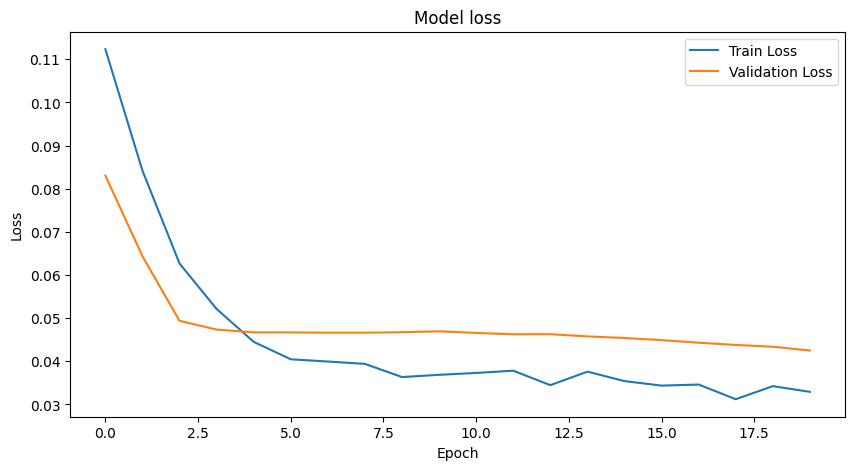

In [8]:
# --- 6. Train LSTM Model ---
print("\nTraining LSTM model...")
history = model_lstm.fit(X_train, y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_test, y_test),
                         verbose=1, # Set to 0 for less output, 1 for progress bar
                         shuffle=False) # Time series data should not be shuffled
print("LSTM model training complete.")

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [9]:
# --- 7. Make Predictions ---
print("\nMaking predictions on the test set...")
y_pred_scaled = model_lstm.predict(X_test)

# Inverse transform predictions to original scale
y_pred_lstm = scaler.inverse_transform(y_pred_scaled)
# y_test needs to be reshaped for inverse_transform if it was also scaled from the original dataframe
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))


Making predictions on the test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


In [10]:
# --- 8. Evaluate the Model ---
print("\nEvaluating LSTM model performance...")
rmse_lstm = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_original_scale, y_pred_lstm)

print(f"  Test Set RMSE: {rmse_lstm:.4f}")
print(f"  Test Set MAE: {mae_lstm:.4f}")
print(f"  Mean of target variable in test set (original scale, {TARGET_VARIABLE}): {np.mean(y_test_original_scale):.4f}")


Evaluating LSTM model performance...
  Test Set RMSE: 106.2672
  Test Set MAE: 81.6201
  Mean of target variable in test set (original scale, svr1): 140.0427


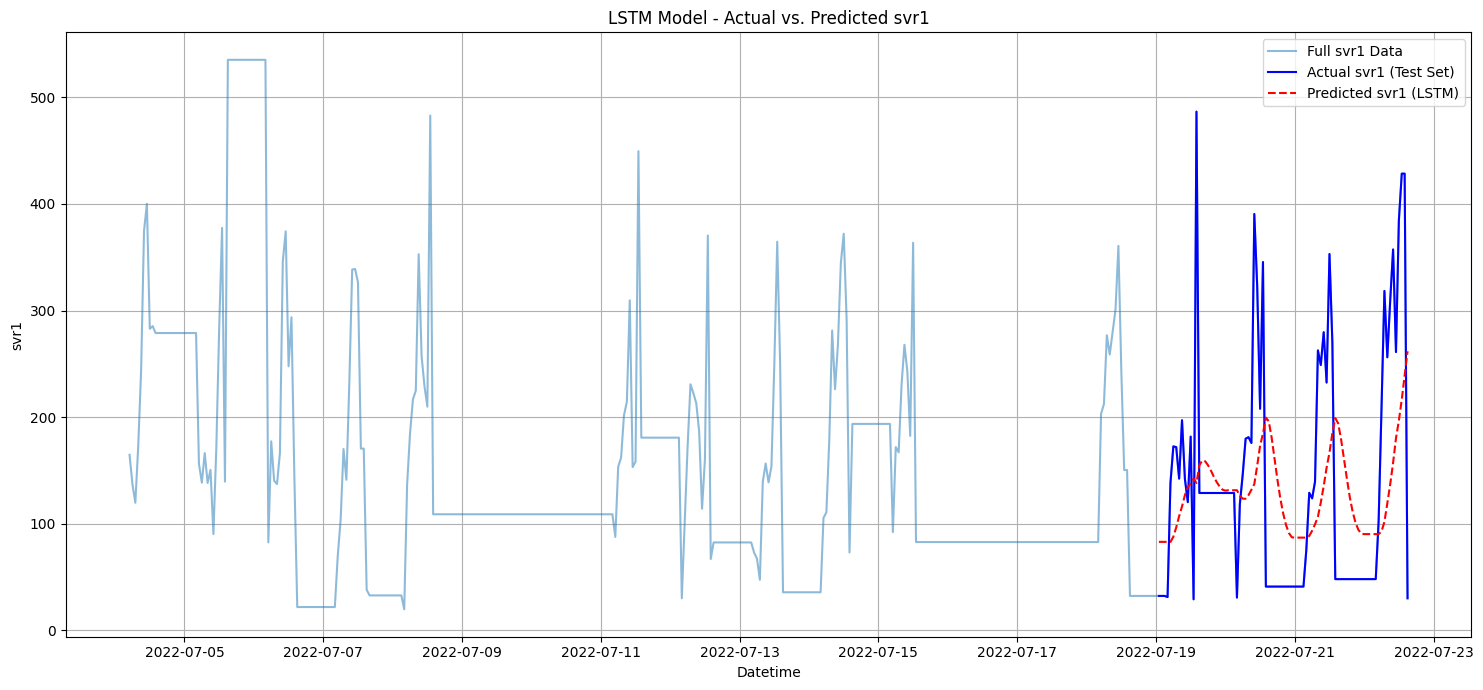

In [11]:
# --- 9. Plotting Predictions vs Actuals ---
# Align predictions with the original dataframe's index for plotting
test_data_index = ts_data_lstm.index[len(ts_data_lstm) - len(y_test_original_scale):]

plt.figure(figsize=(15, 7))
plt.plot(ts_data_lstm.index, ts_data_lstm[TARGET_VARIABLE], label=f'Full {TARGET_VARIABLE} Data', alpha=0.5)
plt.plot(test_data_index, y_test_original_scale, label='Actual ' + TARGET_VARIABLE + ' (Test Set)', color='blue')
plt.plot(test_data_index, y_pred_lstm, label='Predicted ' + TARGET_VARIABLE + ' (LSTM)', color='red', linestyle='--')
plt.title(f'LSTM Model - Actual vs. Predicted {TARGET_VARIABLE}')
plt.xlabel('Datetime')
plt.ylabel(TARGET_VARIABLE)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()